In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import pdb
from matplotlib.colors import ListedColormap

In [177]:
total_class_num = 100
selected_class_num = 3

In [3]:
def normalize_array(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

In [413]:
model_teacher = models.resnet18(num_classes=100)
model_teacher.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_teacher.maxpool = nn.Identity()
model_teacher = torch.nn.DataParallel(model_teacher).cuda()
checkpoint = torch.load('/root/SRE_repro/save/cifar100/resnet18_E200/ckpt.pth')
model_teacher.load_state_dict(checkpoint["state_dict"])
# model_teacher = nn.Sequential(*(list(model_teacher.module.children())[:-1]))
# model_feature_hook.eval()
model_teacher.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [414]:
tsne = TSNE(n_components=2, random_state=42)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']

In [415]:
from torchvision.datasets import CIFAR100
# add inception data augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
cifar100_dataset = CIFAR100(root='/root/SRE_repro/data', train=True, download=True, transform=transform)
cifar100_loader = DataLoader(cifar100_dataset, batch_size=100, shuffle=False)


Files already downloaded and verified


In [416]:
classes = np.random.choice(total_class_num, selected_class_num, replace=False)
classes

array([19, 76, 37])

In [421]:
flag = True
for ci in range(len(classes)):
    class_to_plot = classes[ci]
    print('class_to_plot:', class_to_plot)
    with torch.no_grad():
        for images, batch_labels in cifar100_loader:
            images = images.cuda()
            features_batch = model_teacher(images)
            labels_batch = batch_labels.cpu().numpy()
            # # 找到第一个类别的索引
            class_indices = np.where(labels_batch == class_to_plot)[0]
            # print('class_indices:', class_indices)
            if len(class_indices) == 0:
                continue
            if flag:
                flag = False
                features_batch = features_batch[class_indices].squeeze().cpu().numpy()
                print(features_batch.shape)
                features = features_batch.reshape(-1, 100)

                print('c', ci, 'total', features.shape)
            else:
                features_batch = features_batch[class_indices].cpu().numpy()
                # print(features_batch.shape)
                features = np.concatenate((features, features_batch), axis=0)
                print('c', ci, 'total', features.shape)
    print(features.shape)

class_to_plot: 19
(100,)
c 0 total (1, 100)
c 0 total (3, 100)
c 0 total (5, 100)
c 0 total (6, 100)
c 0 total (7, 100)
c 0 total (8, 100)
c 0 total (10, 100)
c 0 total (11, 100)
c 0 total (13, 100)
c 0 total (14, 100)
c 0 total (16, 100)
c 0 total (17, 100)
c 0 total (18, 100)
c 0 total (19, 100)
c 0 total (21, 100)
c 0 total (22, 100)
c 0 total (23, 100)
c 0 total (24, 100)
c 0 total (26, 100)
c 0 total (27, 100)
c 0 total (28, 100)
c 0 total (29, 100)
c 0 total (31, 100)
c 0 total (32, 100)
c 0 total (33, 100)
c 0 total (35, 100)
c 0 total (37, 100)
c 0 total (38, 100)
c 0 total (40, 100)
c 0 total (42, 100)
c 0 total (44, 100)
c 0 total (45, 100)
c 0 total (46, 100)
c 0 total (48, 100)
c 0 total (49, 100)
c 0 total (50, 100)
c 0 total (52, 100)
c 0 total (54, 100)
c 0 total (55, 100)
c 0 total (56, 100)
c 0 total (58, 100)
c 0 total (60, 100)
c 0 total (64, 100)
c 0 total (65, 100)
c 0 total (67, 100)
c 0 total (68, 100)
c 0 total (69, 100)
c 0 total (70, 100)
c 0 total (71, 100)
c

In [422]:
features_flat = features.reshape(features.shape[0], -1)
features_flat = normalize_array(features_flat)

In [423]:
# mtt_pt = torch.load('../cifar100_50/images_best.pt')
sre2l_pt = torch.load('/root/SRE_repro/syn_data/cifar100_rn18_1k_ipc50/sre_best.pt')
mean_sre2l = torch.mean(sre2l_pt, dim=(0, 2, 3))
std_sre2l = torch.std(sre2l_pt, dim=(0, 2, 3))
std_sre2l

tensor([0.3079, 0.2943, 0.3077])

In [425]:
sre2l_pt.shape

torch.Size([5000, 3, 32, 32])

In [426]:
preprocess = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=mean_sre2l, std=std_sre2l)
])

# select from mtt_pt[classes*50:class*50+50]
# mtt_pt_selected = torch.stack([preprocess(image) for image in mtt_pt[c * 50 : c * 50+50] for c in classes])
# mtt_pt_selected = mtt_pt_selected.cuda()
# mtt_pt_selected.shape
# mtt_pt_selected = mtt_pt[classes*50:classes*50+50]
# data = [preprocess(image) for image in mtt_pt]
data = [preprocess(image) for image in sre2l_pt]
data = torch.stack(data)
data = data.cuda()

In [427]:
with torch.no_grad():
    features_distill = model_teacher(data)

In [428]:
features_distill.shape

torch.Size([5000, 100])

In [429]:
features_distill = features_distill.squeeze().cpu().numpy()
features_distill_flat = features_distill.reshape(features_distill.shape[0], -1)
features_distill_flat = normalize_array(features_distill_flat)

In [430]:
features_distill_flat.shape

(5000, 100)

In [431]:
features_flat_combined = np.concatenate((features_flat, features_distill_flat), axis=0)

In [432]:
features_flat_combined.shape

(6500, 100)

In [433]:
embedded_data_combined = tsne.fit_transform(features_flat_combined)


In [434]:
selected_class_num

3

In [435]:
classes

array([19, 76, 37])

In [ ]:
c100_base = selected_class_num * 500

for i in range(selected_class_num):
    plt.scatter(
        embedded_data_combined[i * 500:(i) * 500+200, 0], 
        embedded_data_combined[i * 500:(i) * 500+200, 1], 
        label=str(classes[i])+' C100', 
        marker='+', 
        c=colors[i]
    )
    plt.scatter(
        # embedded_data_combined[i * 50 + c100_base : (i+1) * 50 + c100_base, 0], 
        # embedded_data_combined[i * 50 + c100_base : (i+1) * 50 + c100_base, 1], 
        embedded_data_combined[classes[i] * 50 + c100_base : (classes[i]+1) * 50 + c100_base, 0], 
        embedded_data_combined[classes[i] * 50 + c100_base : (classes[i]+1) * 50 + c100_base, 1], 
        label=str(classes[i])+' MTT', 
        marker='*', 
        c=colors[i]
        )
plt.legend()

In [ ]:
# 2d histogram


plt.figure(figsize=(12,6))

x1 = embedded_data_combined[0 * 500:(0) * 500+500, 0]
y1 = embedded_data_combined[0 * 500:(0) * 500+500, 1]
x2 = embedded_data_combined[1 * 500:(1) * 500+500, 0]
y2 = embedded_data_combined[1 * 500:(1) * 500+500, 1]
x3 = embedded_data_combined[2 * 500:(2) * 500+500, 0]
y3 = embedded_data_combined[2 * 500:(2) * 500+500, 1]

xmin = min(*x1, *x2, *x3)
xmax = max(*x1, *x2, *x3)
ymin = min(*y1, *y2, *y3)
ymax = max(*y1, *y2, *y3)
ext = (xmin, xmax, ymin, ymax)

hist1 = plt.hexbin(x1, y1, gridsize=100, cmap='Reds', mincnt=0.1, alpha=1, extent=ext)
hist2 = plt.hexbin(x2, y2, gridsize=100, cmap='Blues', mincnt=0.1, alpha=1, extent=ext)
hist3 = plt.hexbin(x3, y3, gridsize=100, cmap='Greens', mincnt=0.1, alpha=1, extent=ext)
plt.colorbar(hist1, orientation='vertical')
plt.colorbar(hist2, orientation='vertical')
plt.colorbar(hist3, orientation='vertical')

plt.show()

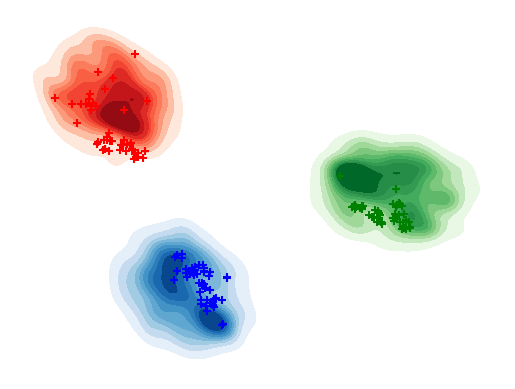

In [436]:
import seaborn as sns
import pandas as pd
sns.set_style("white")

x1 = embedded_data_combined[0 * 500:(0) * 500+500, 0]
y1 = embedded_data_combined[0 * 500:(0) * 500+500, 1]
x2 = embedded_data_combined[1 * 500:(1) * 500+500, 0]
y2 = embedded_data_combined[1 * 500:(1) * 500+500, 1]
x3 = embedded_data_combined[2 * 500:(2) * 500+500, 0]
y3 = embedded_data_combined[2 * 500:(2) * 500+500, 1]

df = pd.DataFrame({
    "x1": x1,
    "y1": y1,
    "x2": x2,
    "y2": y2,
    "x3": x3,
    "y3": y3,
})
sns.kdeplot(x=df.x1, y=df.y1, cmap="Reds", fill=True, bw_adjust=0.9)
sns.kdeplot(x=df.x2, y=df.y2, cmap="Greens", fill=True, bw_adjust=0.9)
sns.kdeplot(x=df.x3, y=df.y3, cmap="Blues", fill=True, bw_adjust=0.9)

c100_base = selected_class_num * 500

for i in range(selected_class_num):
    plt.scatter(
        embedded_data_combined[classes[i] * 50 + c100_base : (classes[i]+1) * 50 + c100_base, 0], 
        embedded_data_combined[classes[i] * 50 + c100_base : (classes[i]+1) * 50 + c100_base, 1], 
        label=str(classes[i])+' MTT', 
        marker='+', 
        c=colors[i]
    )
# remove all axis
plt.axis('off')
plt.show()